In [1]:
import torch
import kornia
import numpy as np
import cv2
# Fixar a semente do Torch para operações específicas
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Importa e plota tensor

In [2]:
#First load libraries and images
import math
import torchvision
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.transforms import transforms, InterpolationMode

img_size =120
batch_size =16
transform = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.Flowers102(root='../data/datasets', split='train',
                                        download=True, transform=transform2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=60,
                                        shuffle=False, num_workers=2)

In [3]:
iterator=iter(trainloader)
img,labels = next(iterator)
print(img.shape,labels.shape)

torch.Size([60, 1, 120, 120]) torch.Size([60])


In [4]:
import kornia

class AugmentationParamsGenerator:
    def __init__(self, n, shape):
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        
        aug_list = kornia.augmentation.AugmentationSequential(
            kornia.augmentation.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
            kornia.augmentation.RandomPerspective(0.1, p=0.7),
            kornia.augmentation.RandomBoxBlur((5,5),p=0.7),
            # kornia.augmentation.RandomEqualize(p=0.3),
            data_keys=["input"],
            same_on_batch=True,
            # random_apply=10,
        )

        self.index = 0
        self.data = []
        for i in range(n):
            out = aug_list(torch.rand(shape))
            self.data.append(aug_list._params)

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.data):
            self.index = 0  # Reset index to start over for circular iteration
            
        result = self.data[self.index]
        self.index += 1
        return result

params_lists =AugmentationParamsGenerator(6,img.shape)

## Processo de detecção e correspondencia com kornia

In [5]:
from kornia.feature import *
# device = torch.device('cpu')
device = torch.device('cuda:0')
PS = 19 # patch size
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = sift
resp = BlobHessian()
scale_pyr = kornia.geometry.ScalePyramid(1, 1.3, PS, double_image=True)
print('scale_pyr ',scale_pyr)
nms = kornia.geometry.ConvQuadInterp3d(15)
n_features = 60

detector = ScaleSpaceDetector(n_features,
                              resp_module=resp,
                              nms_module=nms,
                              scale_pyr_module=scale_pyr,
                              ori_module=kornia.feature.LAFOrienter(PS),
                              minima_are_also_good=True,
                              mr_size=6.0).to(device)

scale_pyr  ScalePyramid(n_levels=1, init_sigma=1.3, min_size=19, extra_levels=3, border=8, sigma_step=2.0, double_image=True)


In [6]:
def detect_and_extract_features(image, detector, descriptor, PS):
    with torch.no_grad():
        lafs, resps = detector(image[None])
        # print('lafs ',lafs.shape,' resps ',resps.shape,' image ',image[None].shape)
        patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, PS)
        B, N, CH, H, W = patches.size()
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        return lafs, descs
    
def detect_extract_feat_in_batch(batch_img, detector, descriptor, PS):
    repo_lafs_desc = []
    with torch.no_grad():
        for image  in batch_img:            
            lafs, resps = detector(image[None])
            patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, PS)

            B, N, CH, H, W = patches.size()
            descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
            repo_lafs_desc.append((lafs,descs))
            
    return repo_lafs_desc

def compute_homography(lafs1, lafs2, matches):
    src_pts = lafs1[0, matches[:, 0], :, 2].data.cpu().numpy()
    dst_pts = lafs2[0, matches[:, 1], :, 2].data.cpu().numpy()
    F, inliers_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 1000)
    inliers_point = matches[torch.from_numpy(inliers_mask).bool().squeeze(), :]
    return inliers_mask

def matching_imagens(ref_img,batch_img, repo_lafs_desc):
    best_match_info = None
    best_match_count = 0
    best_match_index = None
    with torch.no_grad():
        # Detectar e extrair características da imagem de referência
        lafs_ref, descs_ref = detect_and_extract_features(ref_img, detector, descriptor, PS)
        
        for i, (lafs_i, descs_i) in enumerate(repo_lafs_desc):
            # Detectar e extrair características da imagem atual do batch
            # lafs_i, descs_i = detect_and_extract_features(img, detector, descriptor, PS)
            # Comparar as características da imagem de referência com a imagem atual do batch
            scores, matches = kornia.feature.match_snn(descs_ref[0], descs_i[0], 0.85) # correspondencia dos descritories a uma distância de 0.9

            if matches.shape[0] >= 4:
                # Cálculo da homografia
                inliers_mask = compute_homography(lafs_ref, lafs_i, matches)
                # print(lafs_ref[0][None].shape, lafs_ref[0].shape, matches.shape, inliers_mask.shape)

                # Check if this match is better than the previous best match
                if matches.shape[0] > best_match_count:
                    best_match_info = (lafs_ref[0][None].cpu(), lafs_i[0][None].cpu(), matches.cpu(),
                                       kornia.tensor_to_image(ref_img.cpu()), kornia.tensor_to_image(batch_img[i].cpu()),
                                       inliers_mask)
                    best_match_count = matches.shape[0]
                    best_match_index = i

        if best_match_info is not None and best_match_index==0:# TODO: Remove this condition best_match_index==0
            # Plot the best match
            from kornia_moons.viz import draw_LAF_matches

            draw_LAF_matches(
                *best_match_info,
                draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
            )
        # else:
        #     print("No matches found with enough inliers.")
    return best_match_index


  0%|          | 0/17 [00:00<?, ?it/s]

acertos:  551


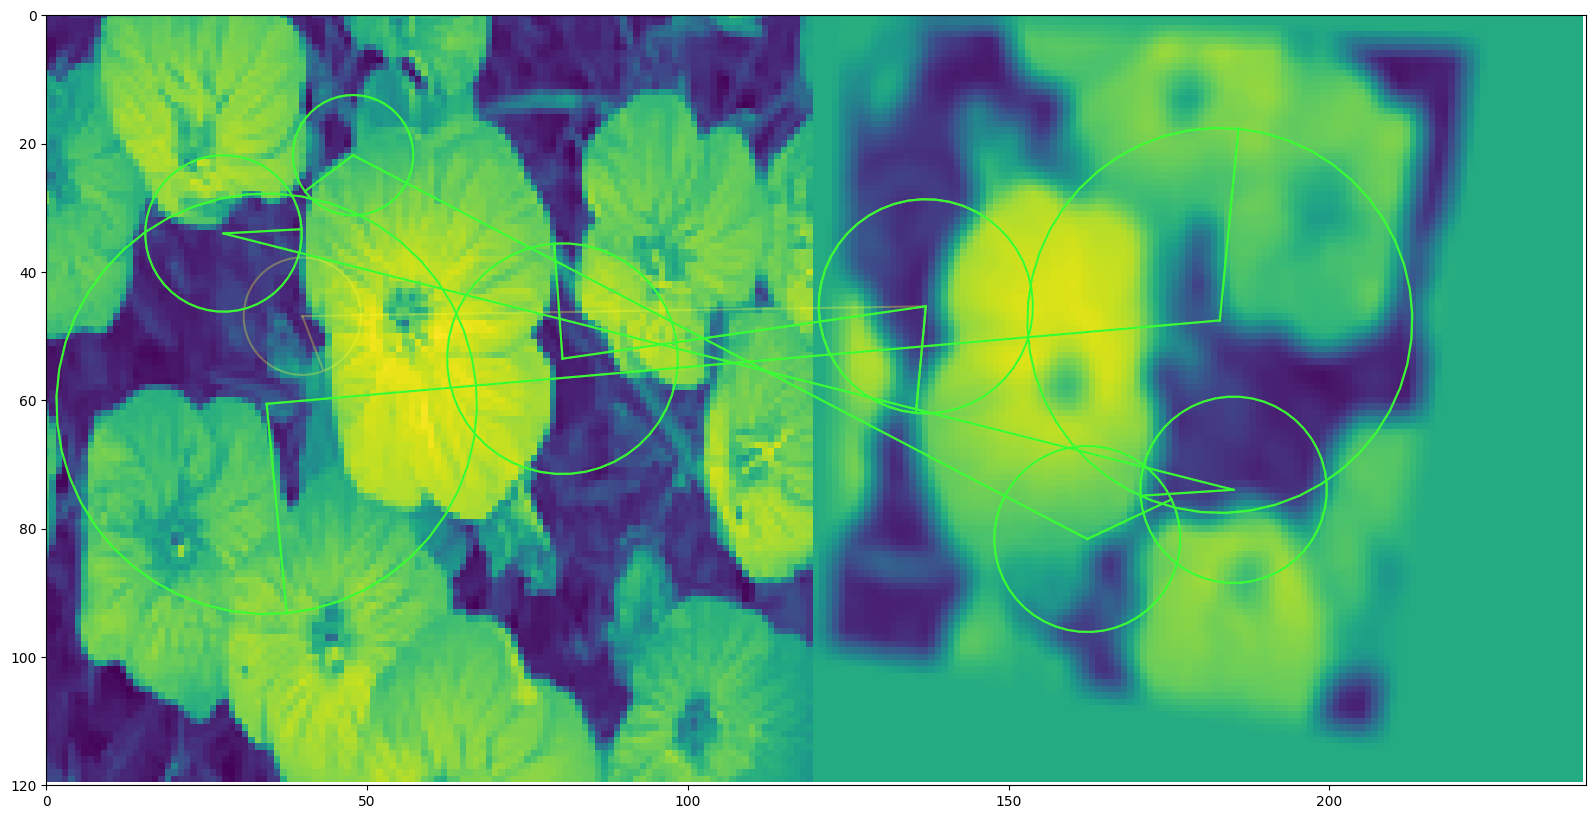

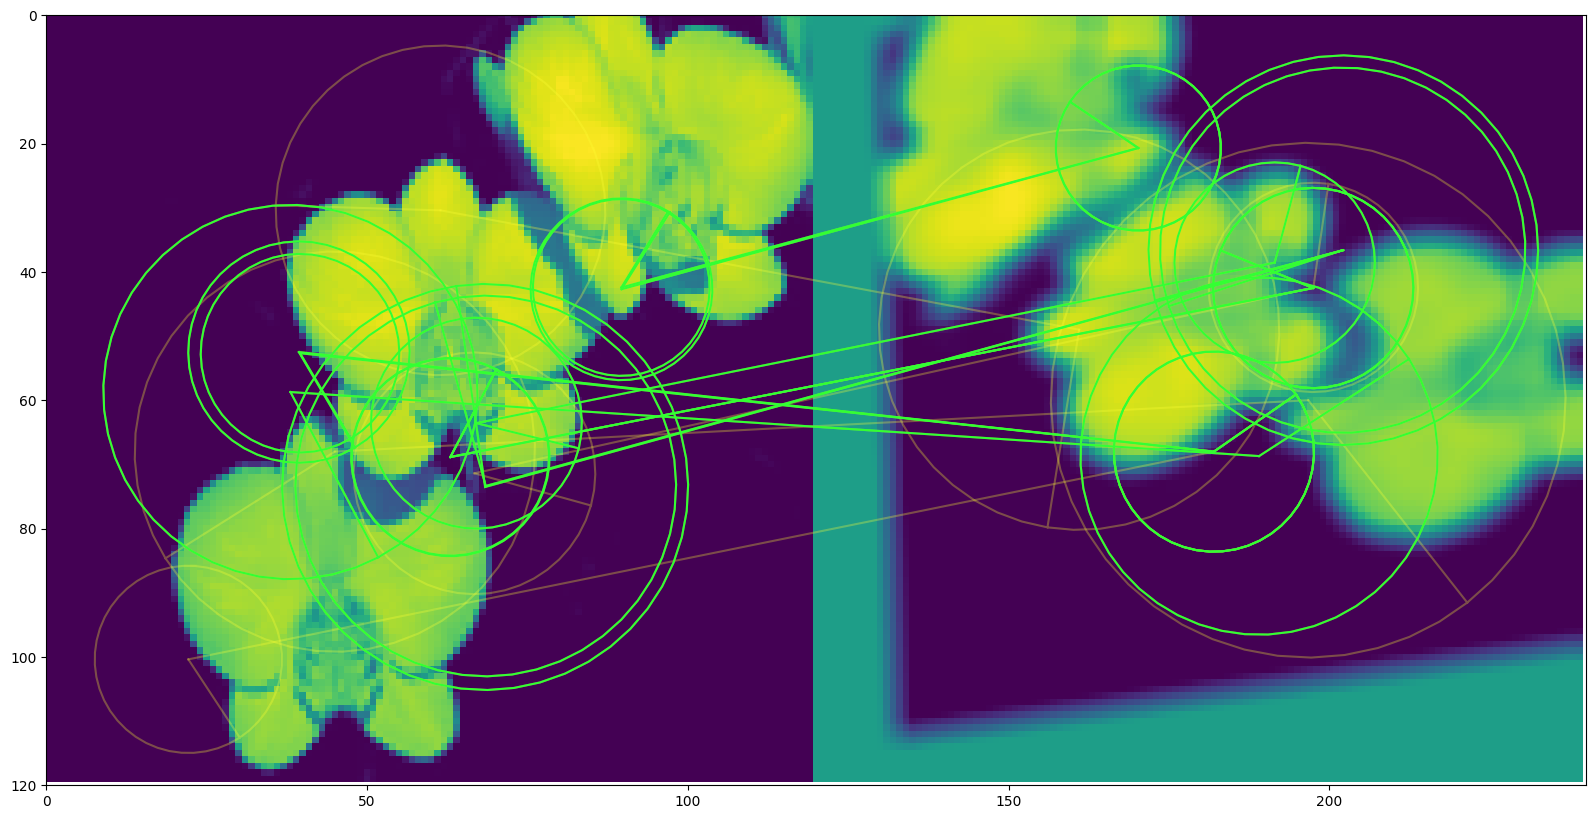

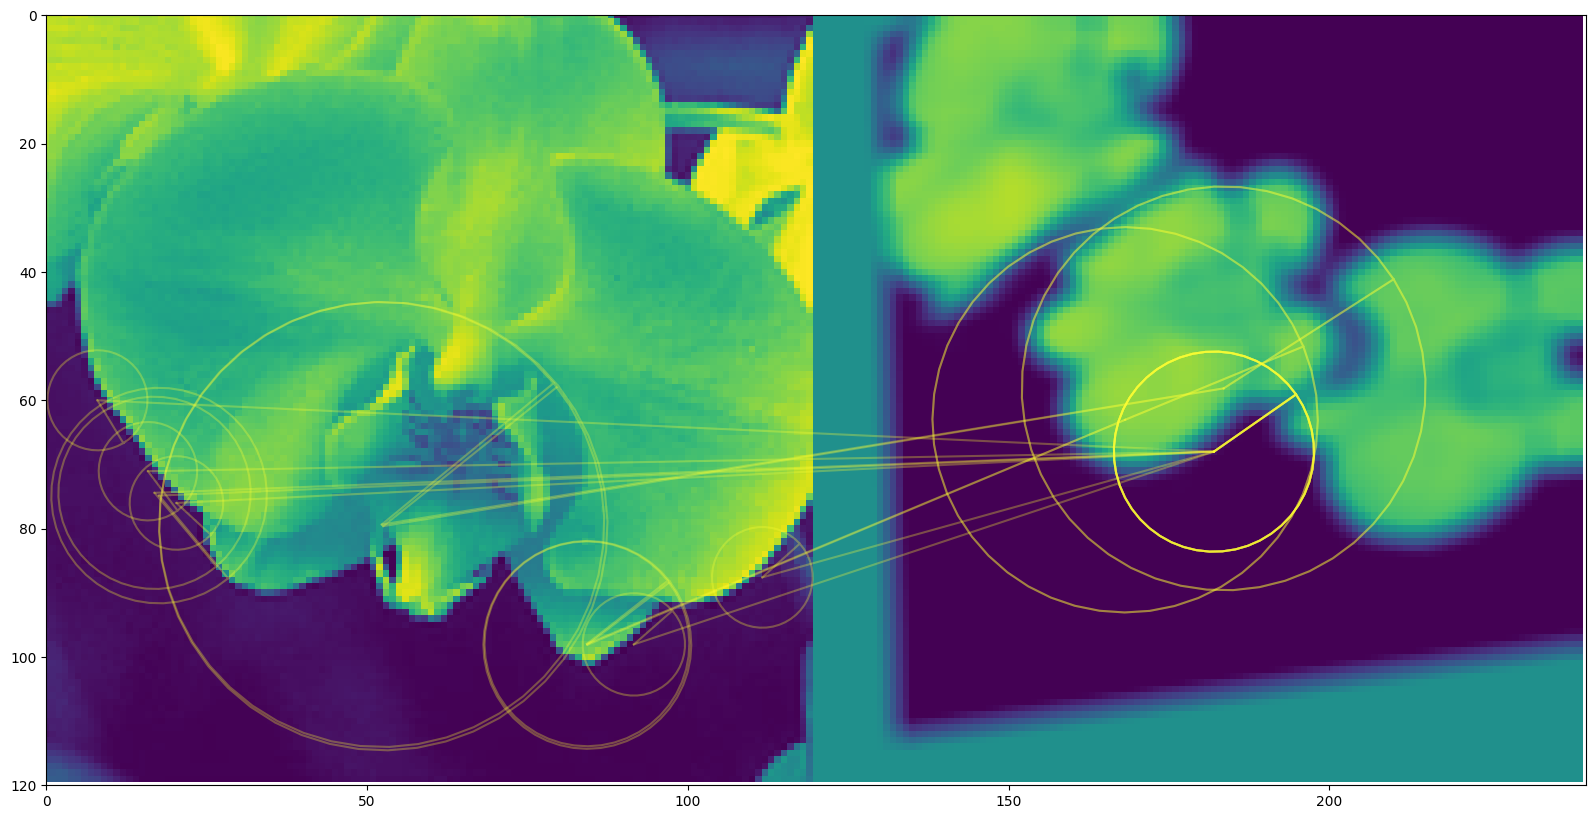

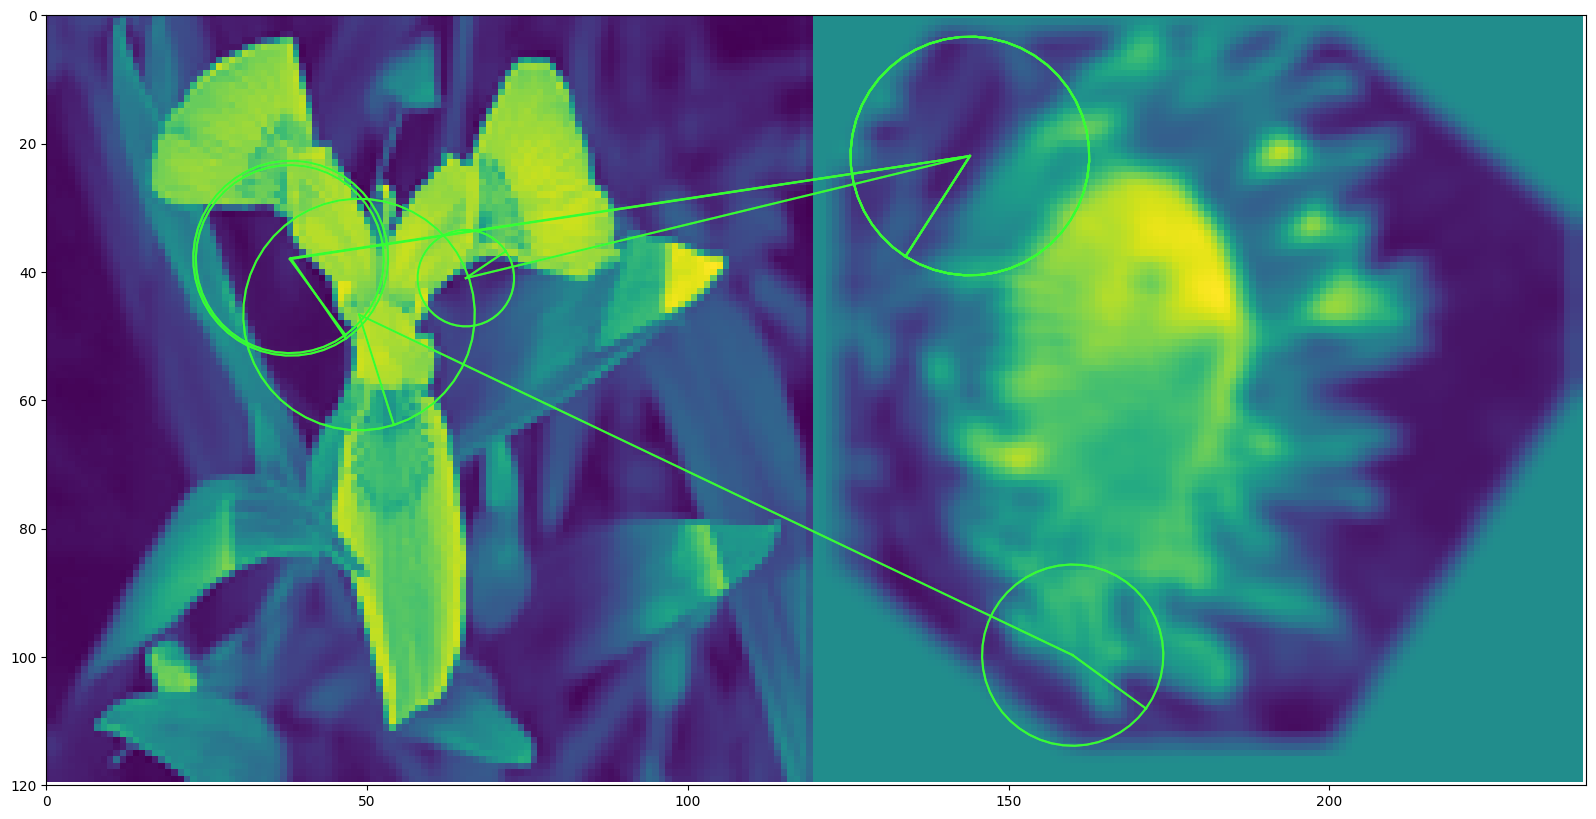

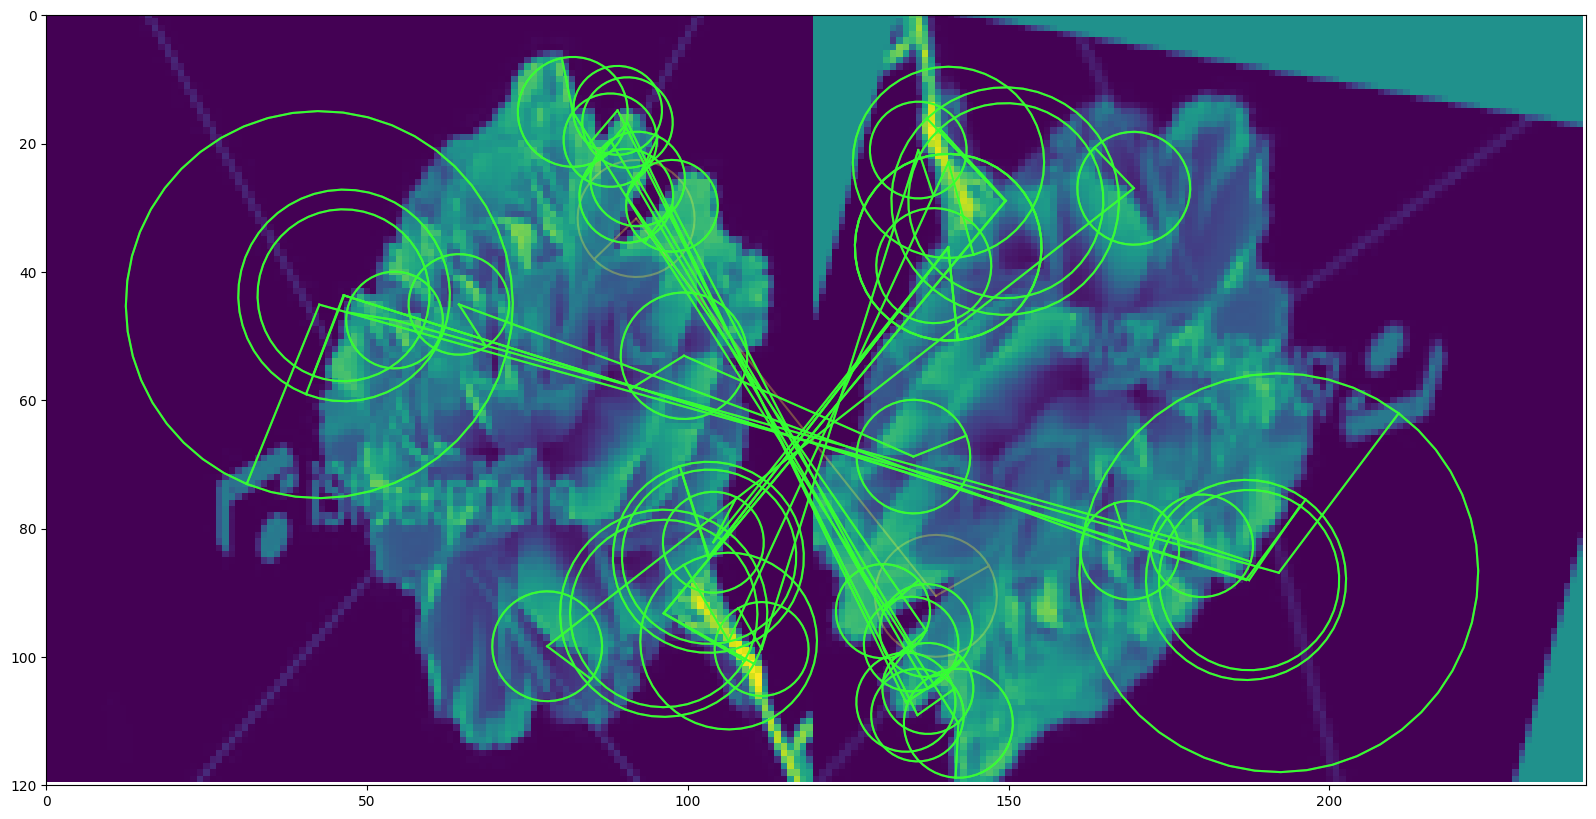

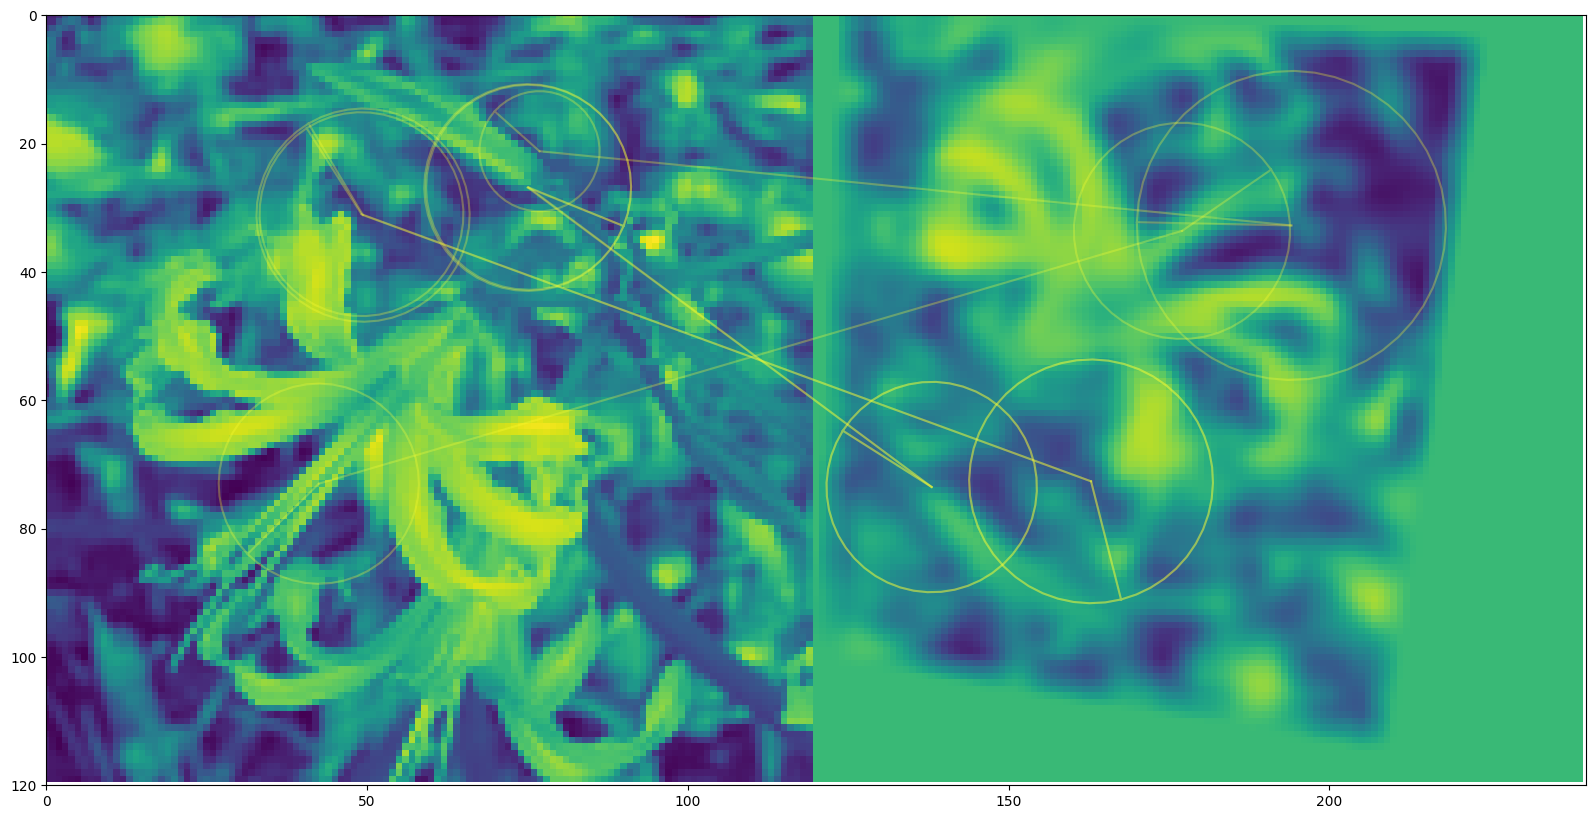

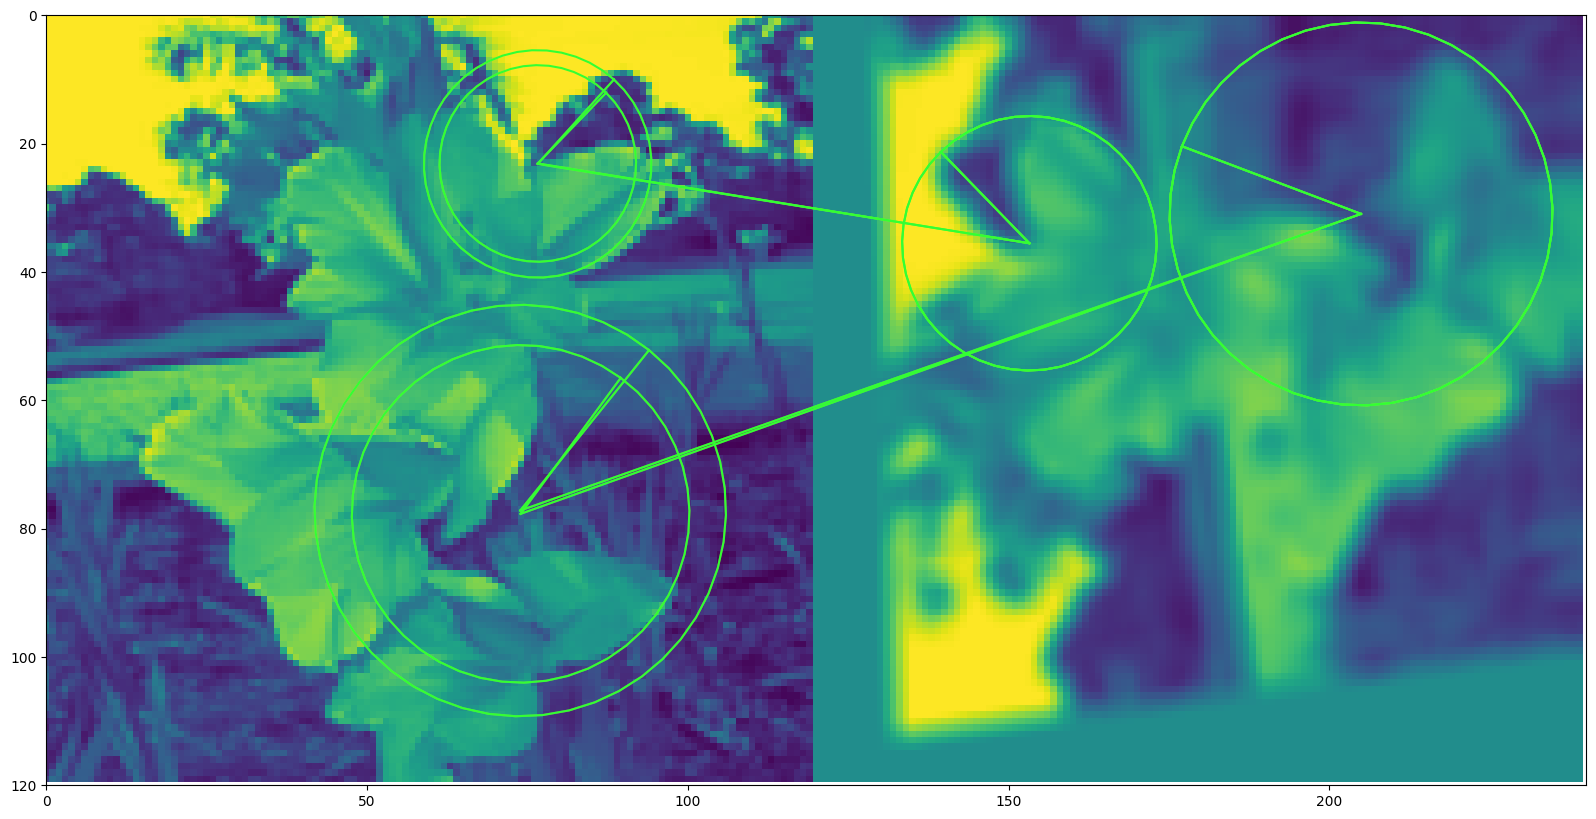

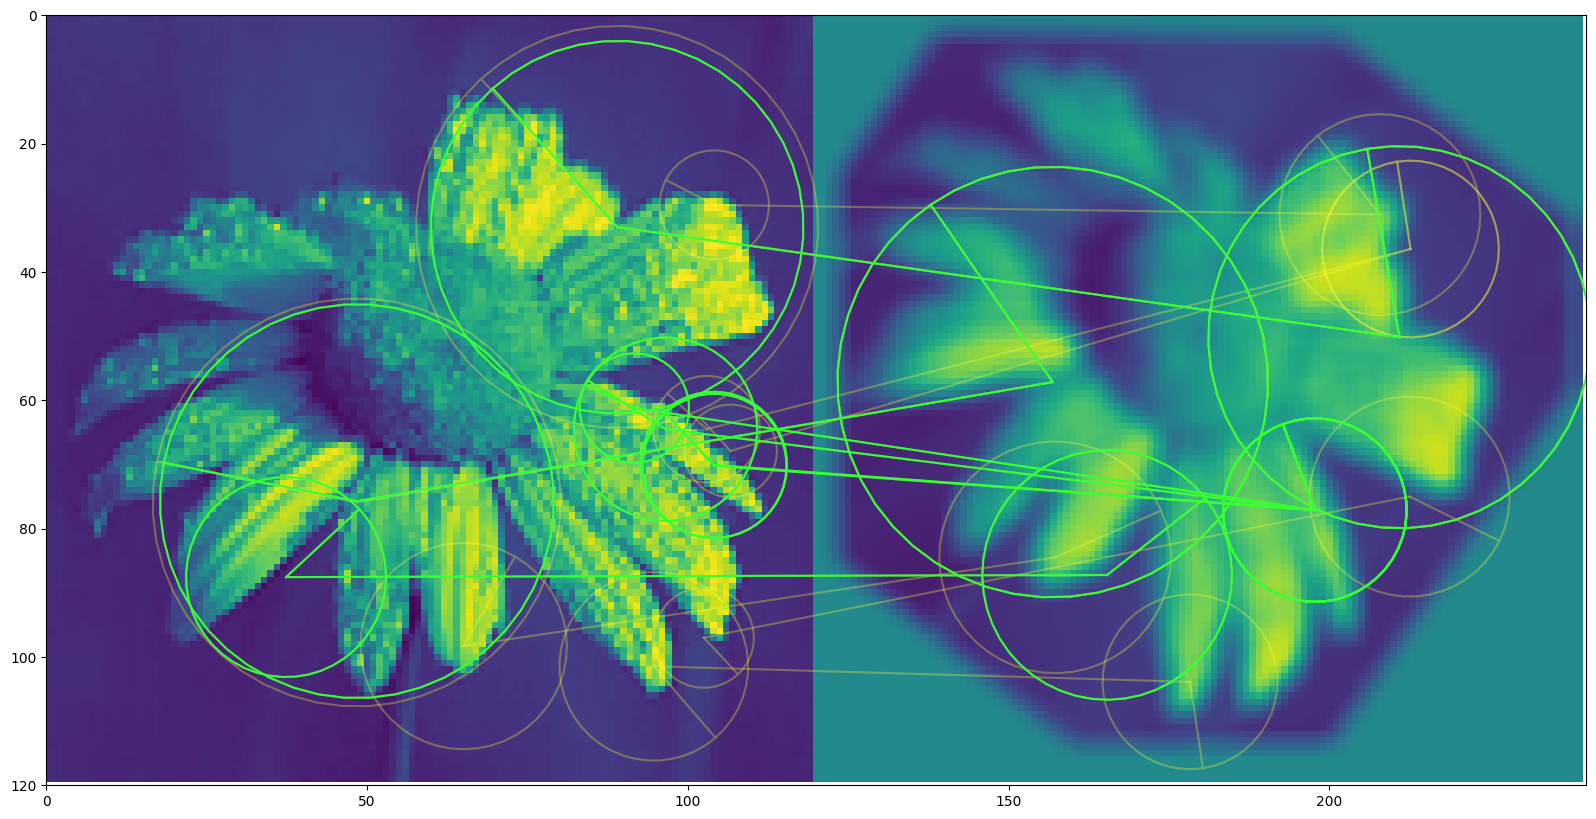

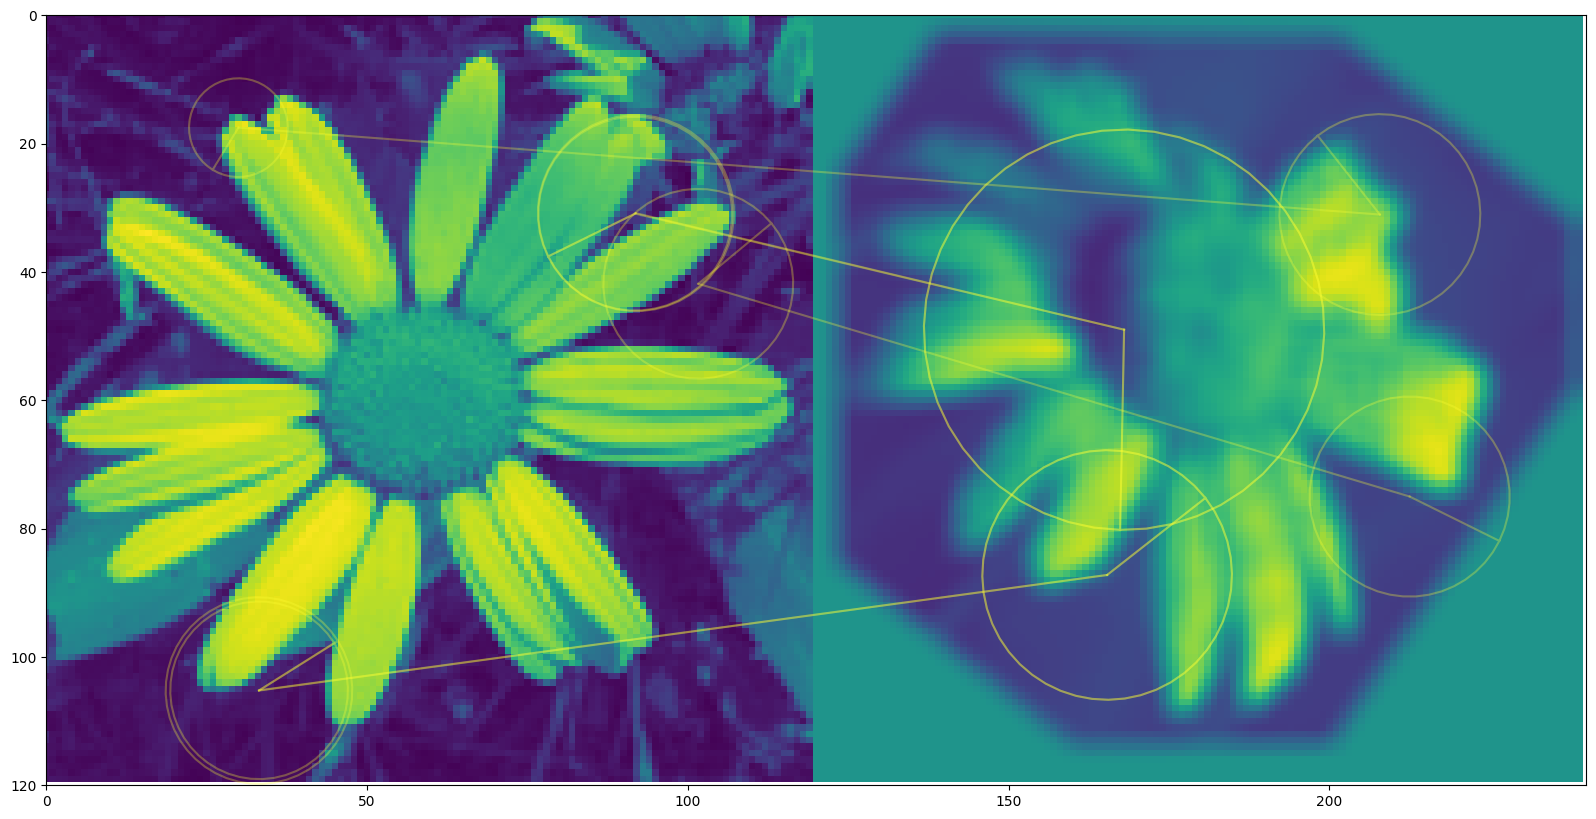

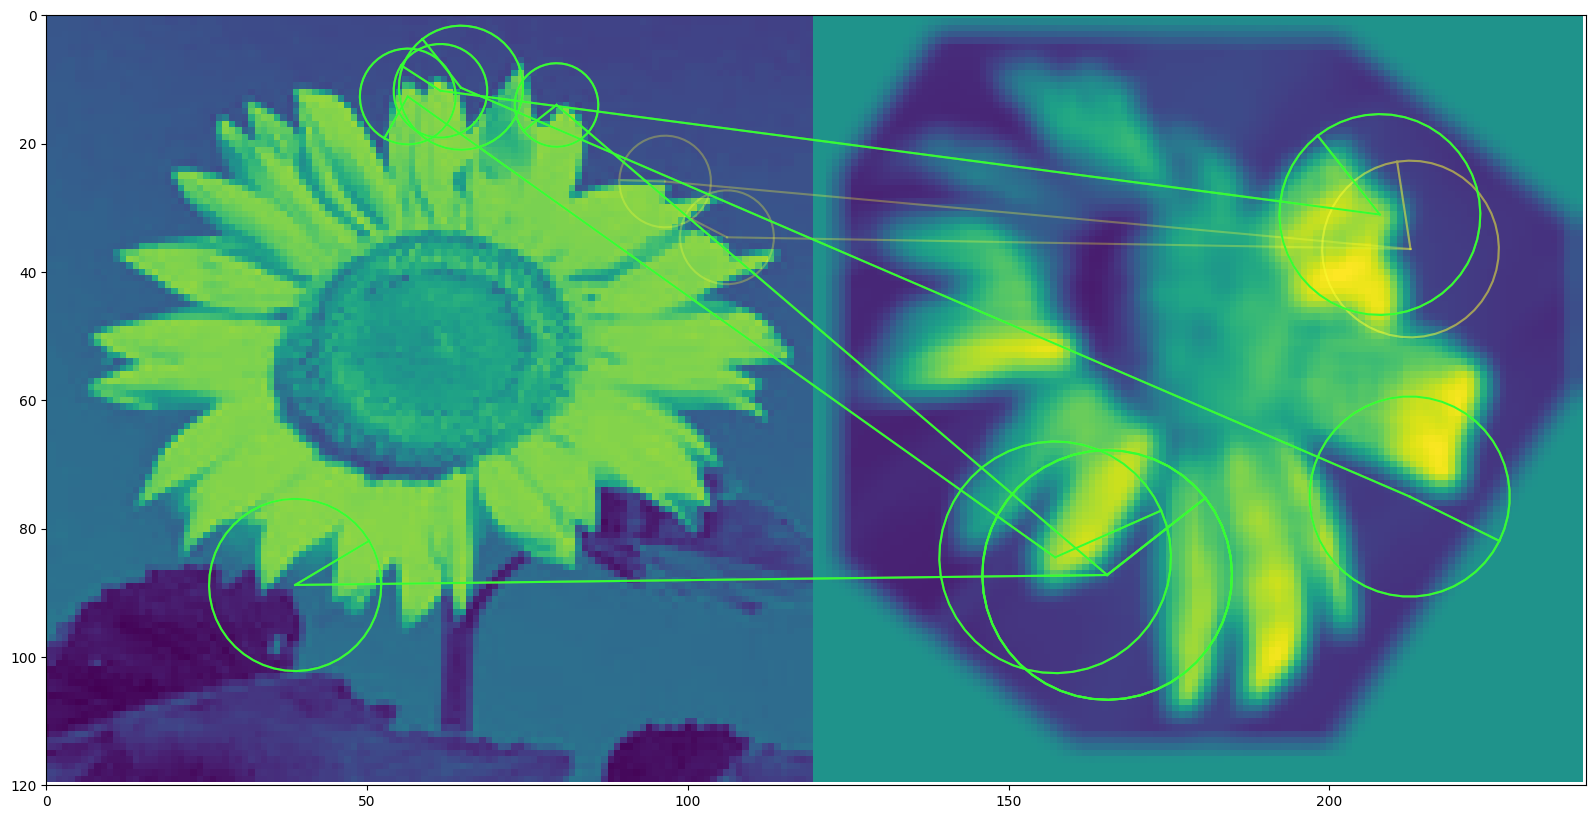

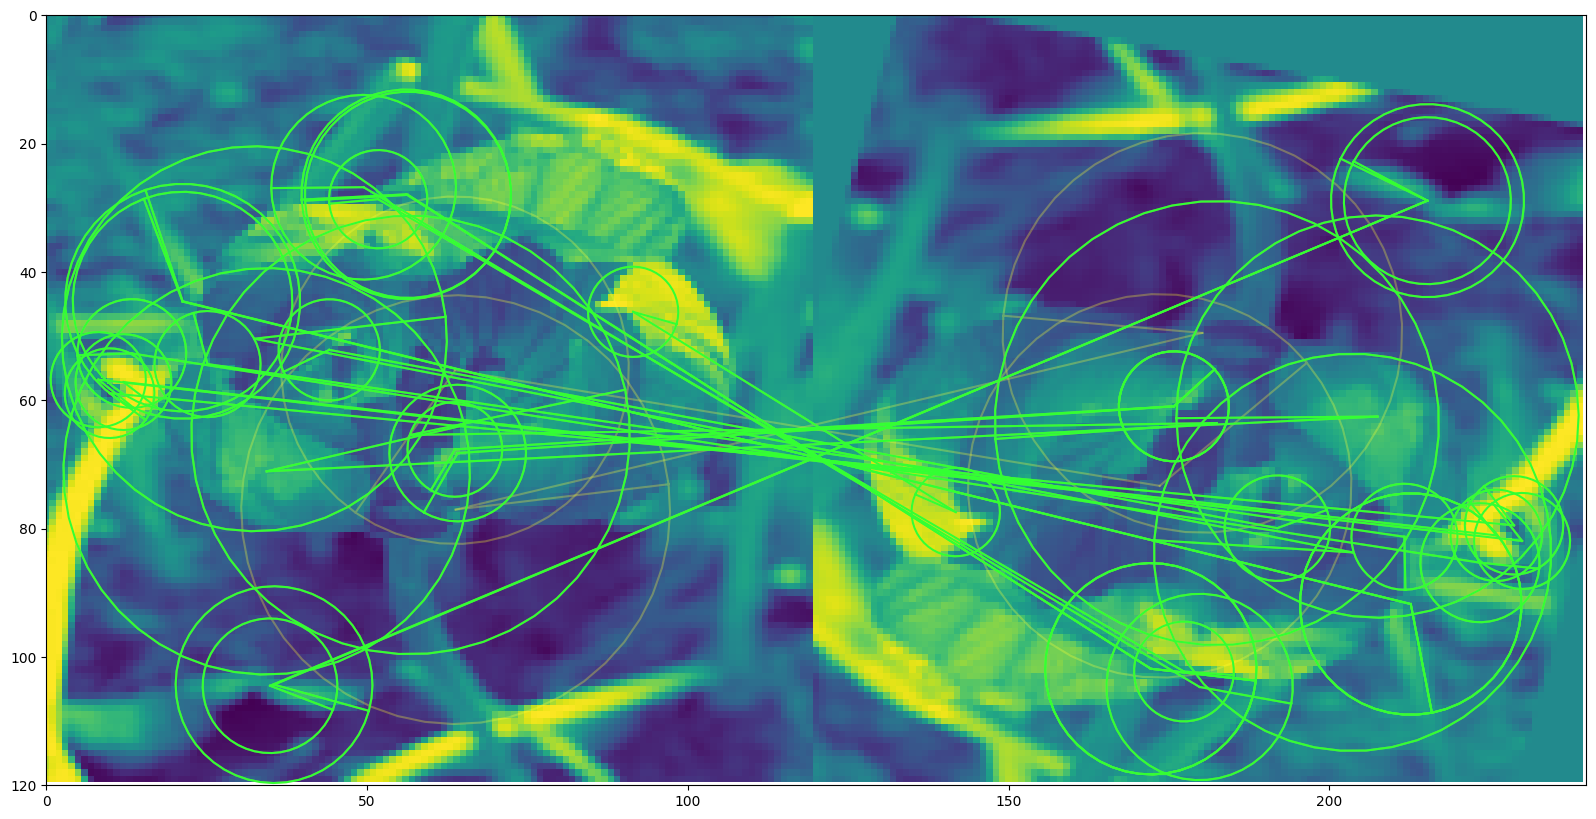

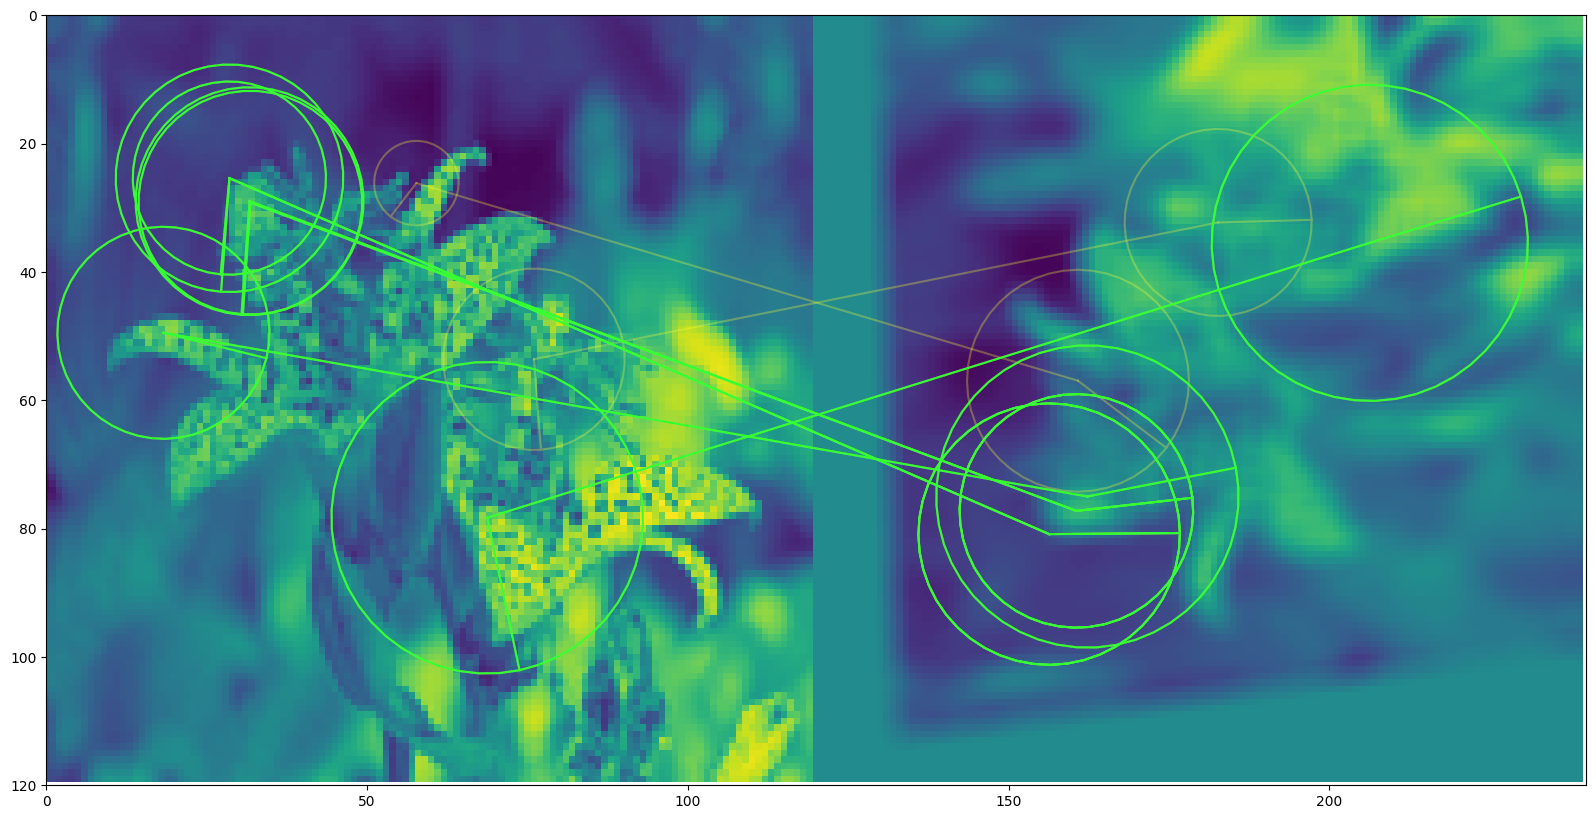

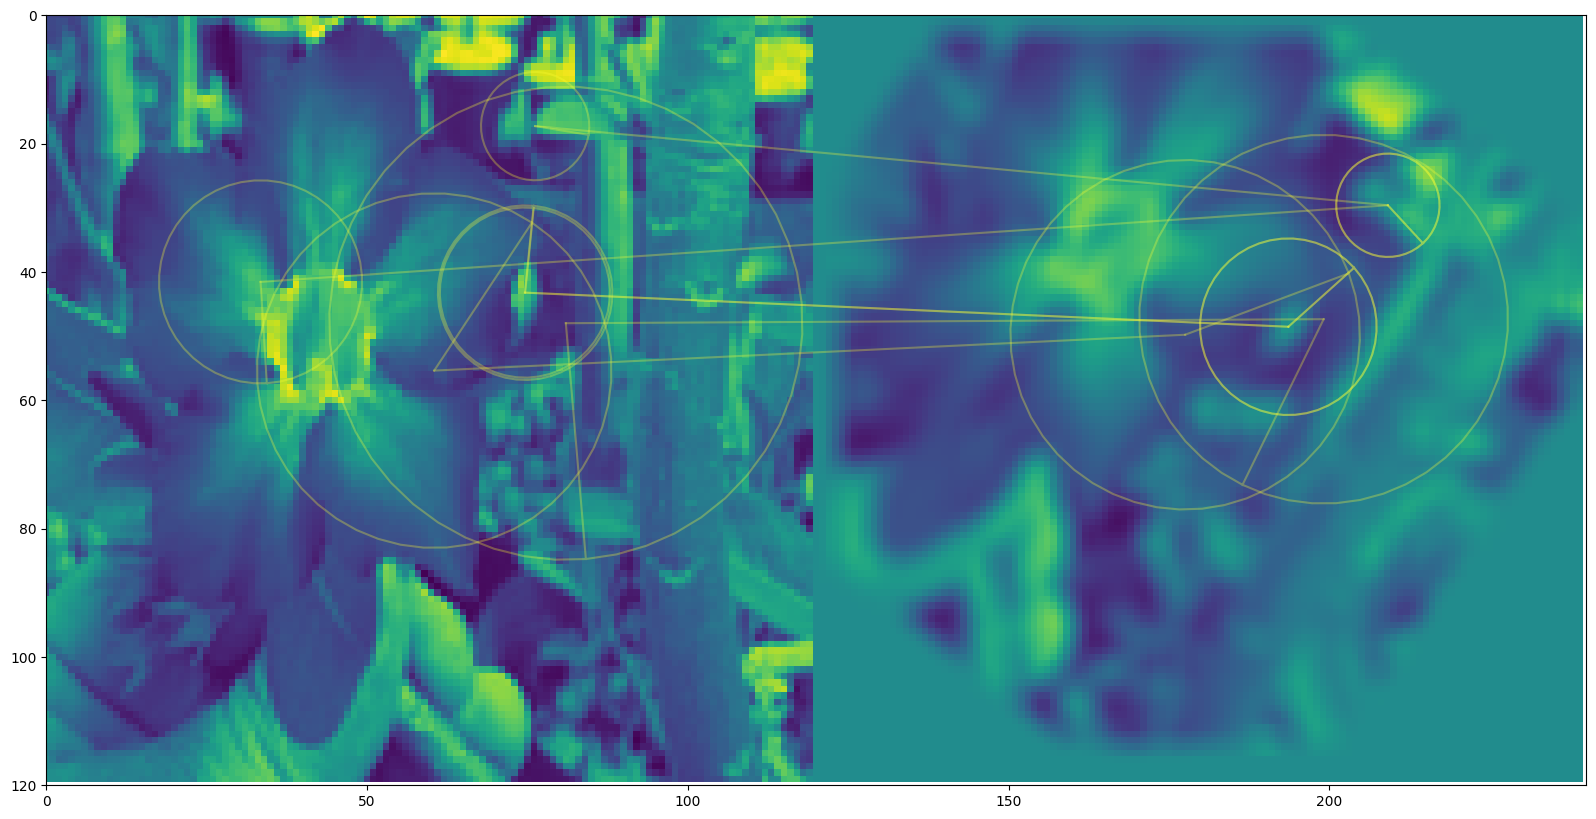

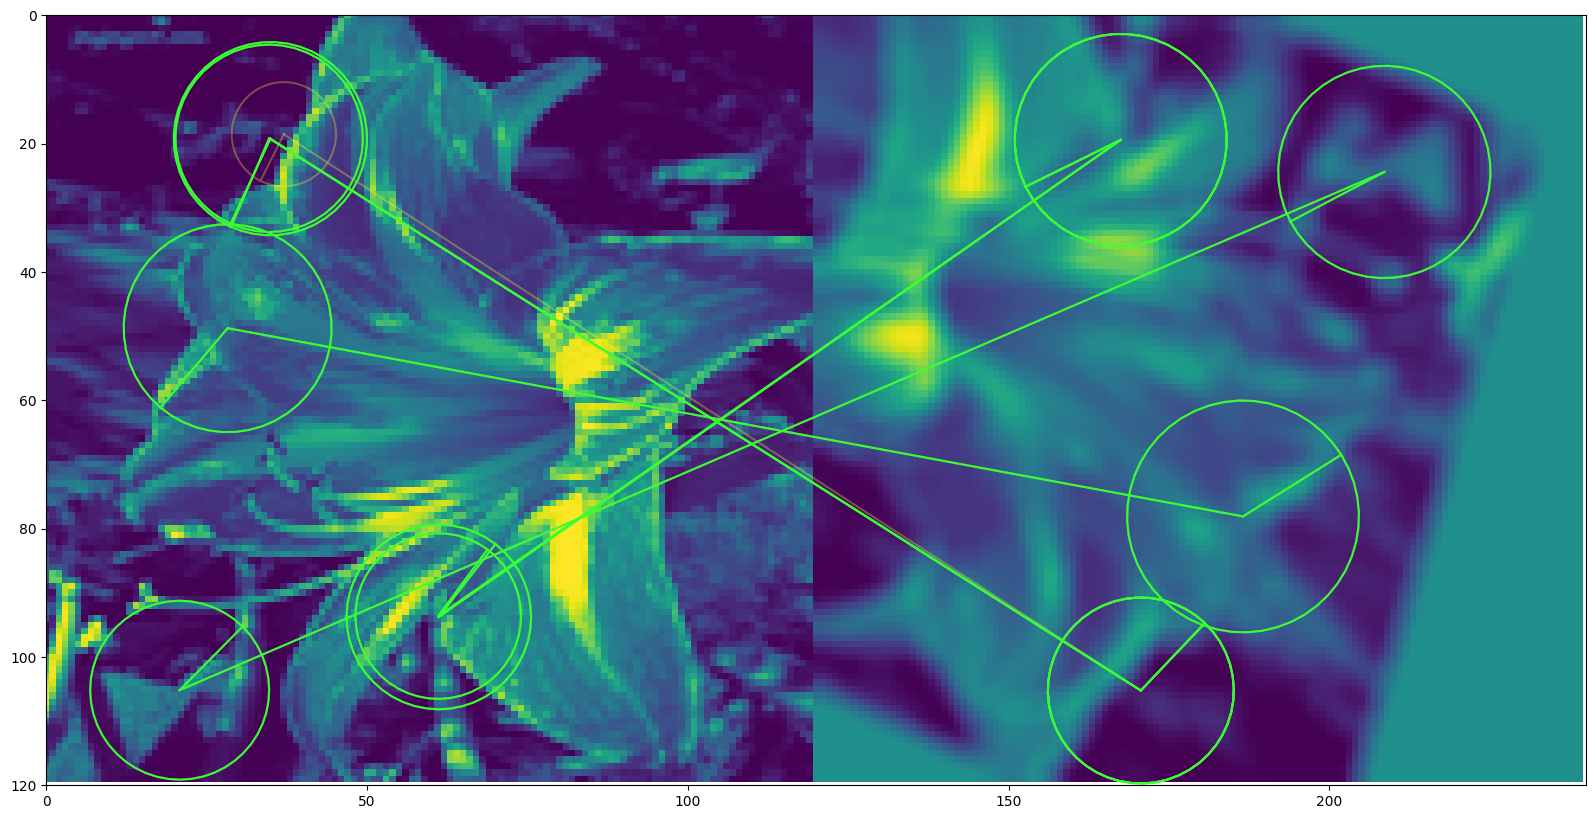

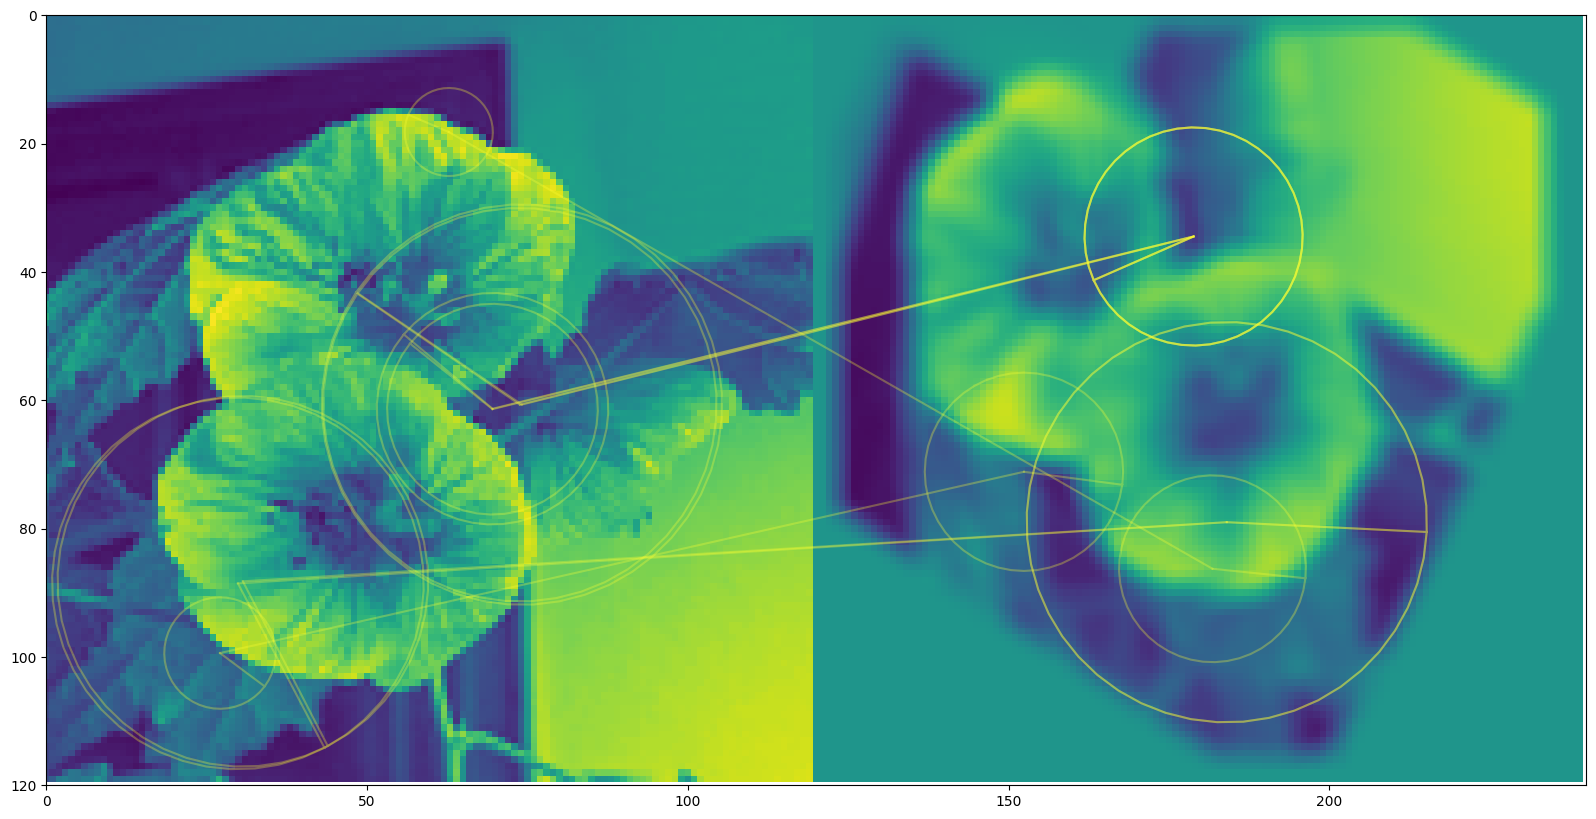

In [7]:
aug_list = kornia.augmentation.AugmentationSequential(
            kornia.augmentation.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
            kornia.augmentation.RandomPerspective(0.1, p=0.7),
            kornia.augmentation.RandomBoxBlur((5,5),p=0.7),
    # kornia.augmentation.RandomEqualize(p=0.3),
    data_keys=["input"],#data_keys=["input", "mask", "bbox", "keypoints"],
    same_on_batch=True,
    # random_apply=15,
)

acertos = 0
total = 0
from tqdm.notebook import tqdm
pbar =  tqdm(trainloader)
for imgs_batch,labels_batch in pbar:# itera em todo dataset
    imgs_batch = imgs_batch.to(device)
    
    params_item = next(params_lists)
    timg_gray_t = aug_list(imgs_batch,params=params_item)
    repo_lafs_desc= detect_extract_feat_in_batch(timg_gray_t,detector,descriptor,PS)
        
    for i,img_gray in enumerate(imgs_batch):# itera em cada batch

        match_index = matching_imagens(img_gray,timg_gray_t,repo_lafs_desc)
        # print("match_index: ",match_index," i: ",i)
        total+=1
        if match_index == i:
            acertos += 1
        pbar.set_description(f"acertos/total: {acertos}/{total}  ")
print("acertos: ",acertos)